In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor, plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets

%matplotlib inline

In [2]:
boston = pd.read_csv('Boston.csv')
boston.head(1)

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0


In [3]:
y = boston['medv']
X = boston.drop(columns=['medv','Unnamed: 0'])

In [4]:
X.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=1)

Comparación de modelos

In [6]:
knn = KNeighborsRegressor().fit(X_train,y_train).predict(X_test).flatten()

In [7]:
lr = LinearRegression().fit(X_train,y_train).predict(X_test).flatten()

In [8]:
lasso = Lasso().fit(X_train,y_train).predict(X_test).flatten()

In [9]:
ridge = Ridge().fit(X_train,y_train).predict(X_test).flatten()

In [10]:
en = ElasticNet().fit(X_train,y_train).predict(X_test).flatten()

In [11]:
dt = DecisionTreeRegressor().fit(X_train,y_train).predict(X_test).flatten()

In [12]:
rf = RandomForestRegressor().fit(X_train,y_train).predict(X_test).flatten()

In [13]:
xgboost = XGBRegressor().fit(X_train,y_train).predict(X_test).flatten()

* Primero guardamos los resultados en listas

In [14]:
outputs = pd.DataFrame(data=[knn,lr,lasso,ridge,en,dt,rf,xgboost]).T
outputs.columns=['knn','lr','lasso','ridge','en','dt','rf','xgboost']
outputs.head()

,knn,lr,lasso,ridge,en,dt,rf,xgboost
0,30.46,32.655032,30.798187,32.511398,31.348467,33.0,30.329,30.359884
1,30.70,28.093495,28.618170,28.265232,28.679029,33.0,28.050,27.026636
2,21.72,18.029018,17.964730,17.528444,17.886279,21.7,19.831,19.176161
3,26.34,21.476716,23.055233,21.330290,22.641323,18.6,20.872,21.448114
4,30.34,18.825439,24.371706,19.680651,23.889703,15.0,19.777,20.703493


In [15]:
from sklearn.metrics import r2_score

* Obtención de R2 en una lista

In [16]:
scores = []

for i in outputs.columns:
    r2 = r2_score(y_test,outputs[i])
    scores.append(r2)

print(scores)

[0.5401612153026705, 0.7634174432138464, 0.6399927356461494, 0.7655800611077146, 0.6662534357446654, 0.8015900911744656, 0.9142506092977072, 0.9085331557145866]


* Transformación de lista a DF

In [17]:
scores = pd.DataFrame(data=scores).T
scores.columns=['knn','lr','lasso','ridge','en','dt','rf','xgboost']
scores

,knn,lr,lasso,ridge,en,dt,rf,xgboost
0,0.540161,0.763417,0.639993,0.76558,0.666253,0.80159,0.914251,0.908533


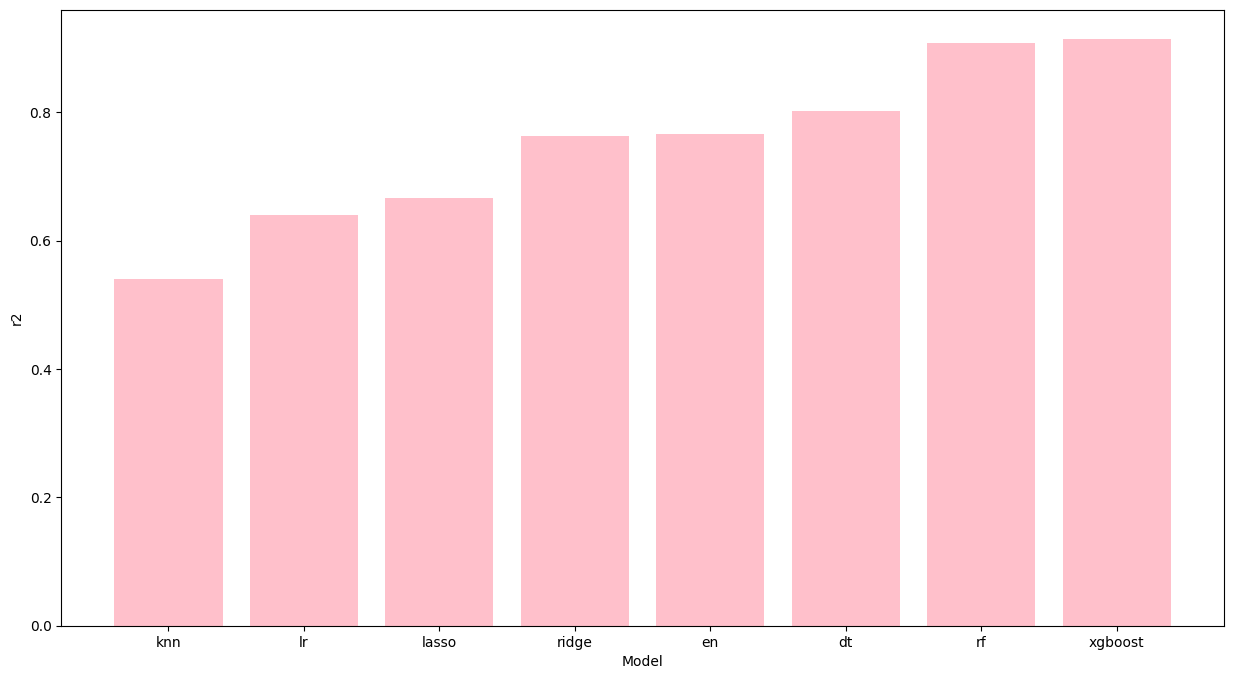

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
plt.bar(scores.columns,sorted(scores.T[0]), color='pink')
plt.ylabel('r2')
plt.xlabel('Model')
plt.show()

* Se observa que XGBoost es el que tiene mejor rendimiento; aunque es muy parecido al desempeño de RF. El de peor desempeño fue el KNN

Mejorando los hiperparámetros de cada modelo

In [19]:
def gs_best(params,model,model_name):
    gs=GridSearchCV(model(), params, cv=5, n_jobs=1, verbose=1)
    gs.fit(X_train,y_train)
    best=model(**gs.best_params_).fit(X_train,y_train)
    y_hat=best.predict(X_test)
    r2=r2_score(y_test,y_hat)

    return best, r2

In [20]:
knn_params={'n_neighbors':[3,5,7,9], 'metric':['manhattan', 'euclidean'], 'weights':['uniform', 'distance']}
lr_params={}
lasso_params={'alpha':[1,100,1000,10000]}
ridge_params={'alpha':[1,100,1000,10000]}
en_params={'max_iter':[100000], 'selection':['cyclic', 'random']}
dt_params= {'max_depth':[3,4,5]}
rf_params={'n_estimators':[2,4,6,8]}
xgboost_params={'max_depth':[4,5], 'n_estimators':[10,20,30], 'learning_rate':[0.3,0.03]}

In [21]:
(model,r2_knn) = gs_best(knn_params,KNeighborsRegressor,'KNN')
print('R2 de KNN:', r2_knn)
(model,r2_lr) = gs_best(lr_params,LinearRegression,'LR')
print('R2 de LR:', r2_lr)
(model,r2_lasso) = gs_best(lasso_params,Lasso,'LASSO')
print('R2 de LASSO:', r2_lasso)
(model,r2_ridge) = gs_best(ridge_params,Ridge,'RIDGE')
print('R2 de RIDGE:', r2_ridge)
(model,r2_en) = gs_best(en_params,ElasticNet,'EN')
print('R2 de EN:', r2_en)
(model,r2_dt) = gs_best(dt_params,DecisionTreeRegressor,'DT')
print('R2 de DT:', r2_dt)
(model,r2_rf) = gs_best(rf_params,RandomForestRegressor,'RF')
print('R2 de RF:', r2_rf)
(model,r2_xgb) = gs_best(xgboost_params,XGBRegressor,'XGB')
print('R2 de XGB:', r2_xgb)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
R2 de KNN: 0.6508830800717474
Fitting 5 folds for each of 1 candidates, totalling 5 fits
R2 de LR: 0.7634174432138464
Fitting 5 folds for each of 4 candidates, totalling 20 fits
R2 de LASSO: 0.6399927356461494
Fitting 5 folds for each of 4 candidates, totalling 20 fits
R2 de RIDGE: 0.7655800611077146
Fitting 5 folds for each of 2 candidates, totalling 10 fits
R2 de EN: 0.6662542980426018
Fitting 5 folds for each of 3 candidates, totalling 15 fits
R2 de DT: 0.7103909677436429
Fitting 5 folds for each of 4 candidates, totalling 20 fits
R2 de RF: 0.91849219349713
Fitting 5 folds for each of 12 candidates, totalling 60 fits
R2 de XGB: 0.9177082576000329


In [22]:
outputs_gs = pd.DataFrame(data=[r2_knn,r2_lr,r2_lasso,r2_ridge,r2_en,r2_dt,r2_rf,r2_xgb]).T
outputs_gs.columns=['knn','lr','lasso','ridge','en','dt','rf','xgboost']
outputs_gs.head()

,knn,lr,lasso,ridge,en,dt,rf,xgboost
0,0.650883,0.763417,0.639993,0.76558,0.666254,0.710391,0.918492,0.917708


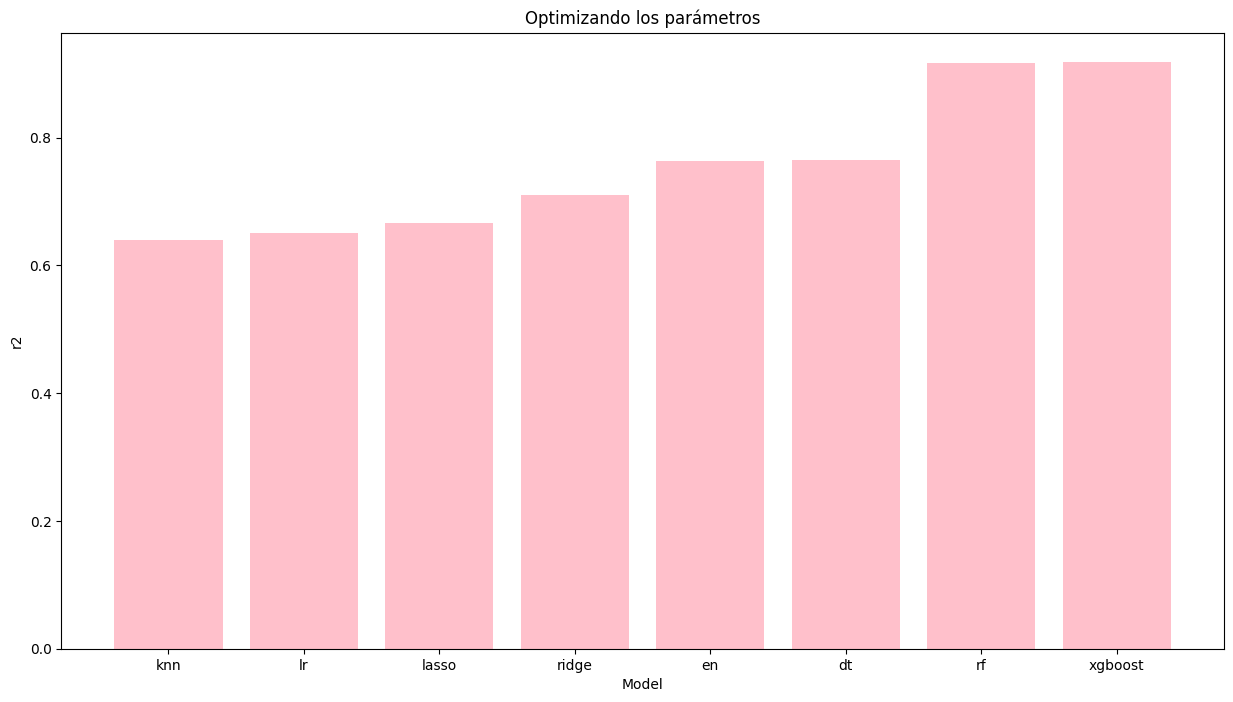

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
plt.bar(outputs_gs.columns,sorted(outputs_gs.T[0]), color='pink')
plt.ylabel('r2')
plt.xlabel('Model')
plt.title('Optimizando los parámetros')
plt.show()

* Nuevamente, con mejor desempeño se encuentre el modelo XGBoost y, marginalmente abajo, RF. El peor modelo, tras optimizar sus parámetros, es Lasso

Ahora, cambiando el parámetro 'max_depth' a 1...

In [24]:
xgboost_params={'max_depth':[1], 'n_estimators':[10,20,30], 'learning_rate':[0.3,0.03]}
(model,r2_xgb) = gs_best(xgboost_params,XGBRegressor,'XGB')
print('R2 de XGB:', r2_xgb)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
R2 de XGB: 0.8608704355144288


Viendo la importancia de las variables

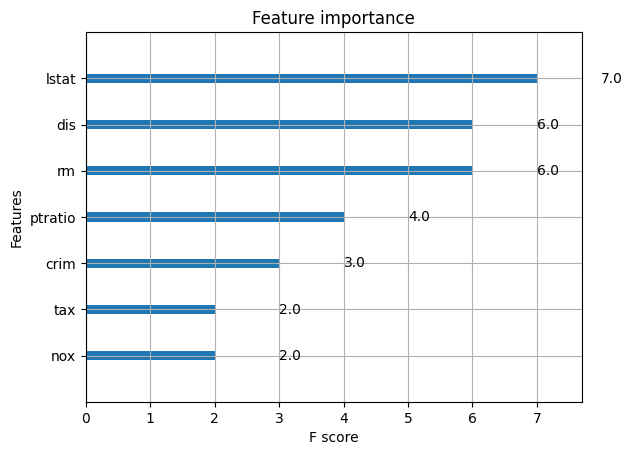

In [25]:
feature_importance = xgb.plot_importance(model)

Graficando los primeros seis boosted trees

In [26]:
xgboost_params={'max_depth':[4,5], 'n_estimators':[10,20,30], 'learning_rate':[0.3,0.03]}
(model,r2_xgb) = gs_best(xgboost_params,XGBRegressor,'XGB')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [27]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=30, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [28]:
xgboost_params={'max_depth':[5], 'learning_rate':[0.3]} 
(model,r2_xgb) = gs_best(xgboost_params,XGBRegressor,'XGB')
# No se utiliza el parámetro n_estimators ya que se utilizará el 30 en num_boost_round dentro de xg_reg

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [29]:
xgboost_params={'max_depth':5, 'learning_rate':0.3} 
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [30]:
xg_reg = xgb.train(params=xgboost_params, dtrain=data_dmatrix, num_boost_round=10)


In [31]:
from sklearn.tree import plot_tree
import graphviz

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

Crear 100 modelos XGBoost \
El primer modelo tendrá 1 árbol, el segundo tendrá 2 árboles,  y continuar hasta hasta el 100. \
Graficar el R-cuadrado en el eje Y vs el número de árboles en el eje X.


In [57]:
r2_xgb = []
for i in range(1,101):
    yhat = XGBRegressor(n_estimators=i).fit(X_train,y_train).predict(X_test).flatten()
    r2 = r2_score(y_test,yhat)
    r2= None if r2 < 0 else r2
    r2_xgb.append(r2)

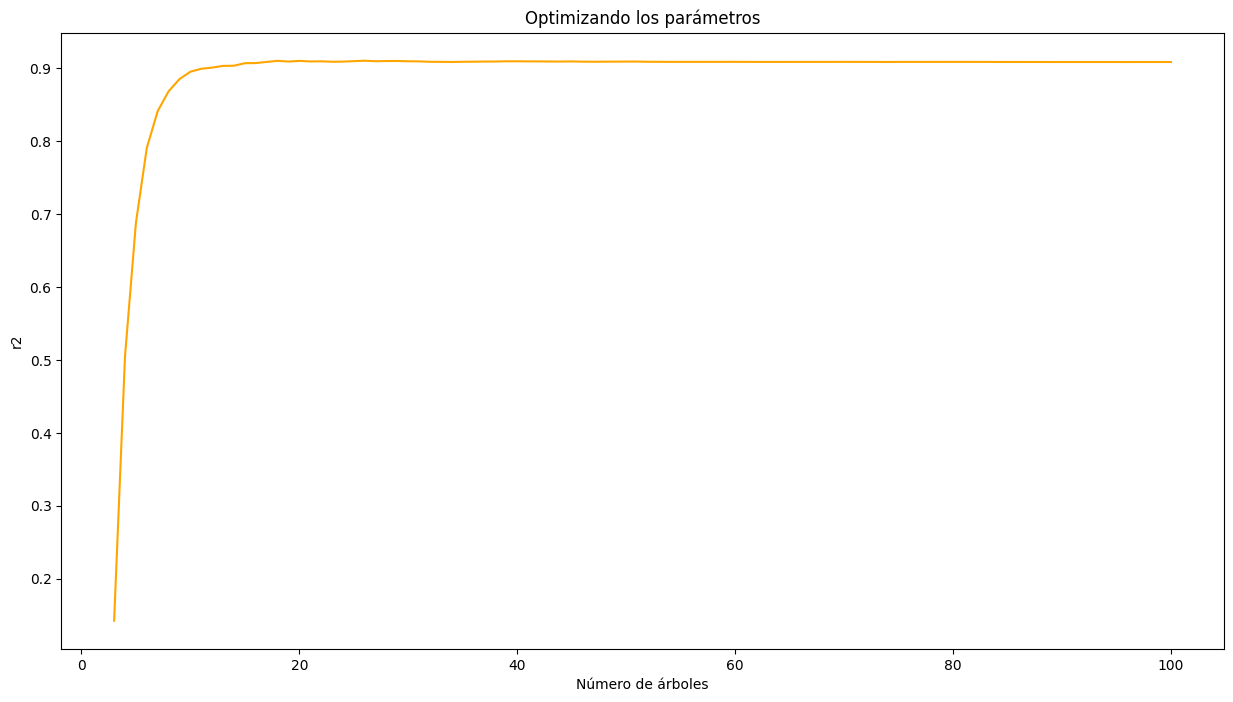

In [58]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(range(1,101),r2_xgb,color='orange')
plt.ylabel('r2')
plt.xlabel('Número de árboles')
plt.title('Optimizando los parámetros')
plt.show()